My notebook is a fork of this amazing kernel : https://www.kaggle.com/abiolatti/train-cv

In [1]:
!pip install -q efficientnet
!pip install -q git+https://github.com/AmedeoBiolatti/dsqol

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import os, re, time, tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics, model_selection

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras 
from tensorflow.keras import backend as K
from efficientnet import tfkeras as efnet

from kaggle_datasets import KaggleDatasets

In [3]:
# my github for trivial but useful functions
from dsqol.tf import imgaug
from dsqol.tf.data import balance
from dsqol.tf.utils import average
from dsqol.tf import losses

In [4]:
# USE DIFFERENT SEED FOR DIFFERENT STRATIFIED KFOLD
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

TIME_BUDGET = 2.5 * 3600 # time budget allocated for the training (Kaggle has 3 hours max time)

# 
#FOLDS = 5

FOLDS = 5
INCLUDE_2019 = 0
INCLUDE_2018 = 1
INCLUDE_MALIGNANT = 0

# DATA PARAMS
IMG_READ_SIZE     = 384
IMG_SIZE          = 384
BALANCE_POS_RATIO = 0.08

# MODEL PARAMS
EFF_NET      = 6
# loss and loss params
LOSS_TYPE    = 'BCE' # 'BCE', 'FOCAL'
LOSS_PARAMS  = dict(label_smoothing=0.09)

# TRAINING PARAMS
BATCH_SIZE  = 16
EPOCHS      = 25
# lr schedule

# VALID AND TEST PARAMS
TBM        = 6
TTA        = 30
tta        = 30
VALID_FREQ = 1
N_SWA      = 3
SWA_DECAY  = 0.9

In [5]:
DEVICE = "TPU"
print("connecting to TPU...")
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    print("Could not connect to TPU")
    tpu = None
if tpu:
    try:
        print("initializing  TPU ...")
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.experimental.TPUStrategy(tpu)
        print("TPU initialized")
    except _:
        print("failed to initialize TPU")
else:
    DEVICE = "GPU"

if DEVICE != "TPU":
    print("Using default strategy for CPU and single GPU")
    strategy = tf.distribute.get_strategy()

if DEVICE == "GPU":
    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
    
AUTO              = tf.data.experimental.AUTOTUNE
REPLICAS          = strategy.num_replicas_in_sync
GLOBAL_BATCH_SIZE = BATCH_SIZE * REPLICAS
print("REPLICAS: %d" % REPLICAS)

connecting to TPU...
Running on TPU  grpc://10.0.0.2:8470
initializing  TPU ...
TPU initialized
REPLICAS: 8


## Preprocessing

https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/169139

In [6]:
GCS_PATH1 = KaggleDatasets().get_gcs_path('melanoma-%ix%i' % (IMG_READ_SIZE, IMG_READ_SIZE))
GCS_PATH2 = KaggleDatasets().get_gcs_path('isic2019-%ix%i' % (IMG_READ_SIZE, IMG_READ_SIZE))
GCS_PATH3 = KaggleDatasets().get_gcs_path('malignant-v2-%ix%i' % (IMG_READ_SIZE, IMG_READ_SIZE))

In [7]:
df_base_train = pd.read_csv("../input/siim-isic-melanoma-classification/train.csv")
df_base_test = pd.read_csv("../input/siim-isic-melanoma-classification/test.csv")

In [8]:
train_files = tf.io.gfile.glob(os.path.join(GCS_PATH1, "train*.tfrec"))
#
if INCLUDE_2019:
    train_files += tf.io.gfile.glob([os.path.join(GCS_PATH2, "train%.2i*.tfrec" % i) for i in range(1, 30, 2)])
if INCLUDE_2018:
    train_files += tf.io.gfile.glob([os.path.join(GCS_PATH2, "train%.2i*.tfrec" % i) for i in range(0, 30, 2)])
#
if INCLUDE_MALIGNANT:
    train_files += tf.io.gfile.glob([os.path.join(GCS_PATH3, "train%.2i*.tfrec" % i) for i in range(15, 30, 1)])
print("%d train files found" % len(train_files))

30 train files found


In [9]:
test_files = tf.io.gfile.glob(os.path.join(GCS_PATH1, "test*.tfrec"))
print("%d test files found" % len(test_files))

16 test files found


## Data pipeline

In [10]:
def read_labeled_tfrecord(example):
    tfrec_format = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_name'                   : tf.io.FixedLenFeature([], tf.string),
        #'patient_id'                   : tf.io.FixedLenFeature([], tf.int64),
        #'sex'                          : tf.io.FixedLenFeature([], tf.int64),
        #'age_approx'                   : tf.io.FixedLenFeature([], tf.int64),
        #'anatom_site_general_challenge': tf.io.FixedLenFeature([], tf.int64),
        #'diagnosis'                    : tf.io.FixedLenFeature([], tf.int64),
        'target'                       : tf.io.FixedLenFeature([], tf.int64)
    }           
    example = tf.io.parse_single_example(example, tfrec_format)
    return example['image'], example['target']


def read_unlabeled_tfrecord(example, return_image_name=True):
    tfrec_format = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_name'                   : tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, tfrec_format)
    return example['image'], example['image_name'] if return_image_name else 0


def prepare_image(img):    
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.cast(img, tf.float32) / 255.0           
    return img


def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) 
         for filename in filenames]
    return np.sum(n)

In [11]:
# https://www.kaggle.com/cdeotte/tfrecord-experiments-upsample-and-coarse-dropout
def dropout(image, DIM=256, PROBABILITY = 0.75, CT = 8, SZ = 0.2):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image with CT squares of side size SZ*DIM removed
    
    # DO DROPOUT WITH PROBABILITY DEFINED ABOVE
    P = tf.cast( tf.random.uniform([],0,1)<PROBABILITY, tf.int32)
    if (P==0)|(CT==0)|(SZ==0): 
        return image
    
    for k in range(CT):
        # CHOOSE RANDOM LOCATION
        x = tf.cast( tf.random.uniform([],0,DIM),tf.int32)
        y = tf.cast( tf.random.uniform([],0,DIM),tf.int32)
        # COMPUTE SQUARE 
        WIDTH = tf.cast( SZ*DIM,tf.int32) * P
        ya = tf.math.maximum(0,y-WIDTH//2)
        yb = tf.math.minimum(DIM,y+WIDTH//2)
        xa = tf.math.maximum(0,x-WIDTH//2)
        xb = tf.math.minimum(DIM,x+WIDTH//2)
        # DROPOUT IMAGE
        one = image[ya:yb,0:xa,:]
        two = tf.zeros([yb-ya,xb-xa,3]) 
        three = image[ya:yb,xb:DIM,:]
        middle = tf.concat([one,two,three],axis=1)
        image = tf.concat([image[0:ya,:,:],middle,image[yb:DIM,:,:]],axis=0)
            
    # RESHAPE HACK SO TPU COMPILER KNOWS SHAPE OF OUTPUT TENSOR 
    image = tf.reshape(image,[DIM,DIM,3])
    return image

In [12]:
def base_aug(img):
    img = tf.image.random_flip_left_right(img)
    img = dropout(img, DIM=IMG_READ_SIZE, PROBABILITY=0.6, CT=6, SZ=0.12)
    #img = tf.image.random_hue(img, 0.01)
    img = tf.image.random_saturation(img, 0.7, 1.3)
    img = tf.image.random_contrast(img, 0.8, 1.2)
    img = tf.image.random_brightness(img, 0.1)
    
    return img


dropout_aug = lambda img: dropout(img, DIM=IMG_READ_SIZE, PROBABILITY=0.5, CT=8, SZ=0.2)
transform_aug = imgaug.Transform(dim=IMG_READ_SIZE)


def basic_augmentation_pipeline(ds: tf.data.Dataset, dim=None, batch_size=None) -> tf.data.Dataset:
    ds = ds.map(lambda i, o: (transform_aug(i), o), num_parallel_calls=AUTO)
    ds = ds.map(lambda i, o: (base_aug(i), o), num_parallel_calls=AUTO)
    return ds

In [13]:
def get_dataset(files, augment=False, repeat=False, shuffle=False, labeled=True, batch_size=16, drop_remainder=False, 
                dim=256, read_dim=None
               ) -> tf.data.Dataset:
    if read_dim is None:
        read_dim = dim
    
    ds = tf.data.TFRecordDataset(files, num_parallel_reads=AUTO)
    ds = ds.cache()
    
    if repeat:
        ds = ds.repeat()
    
    if shuffle: 
        ds = ds.shuffle(1024 * 8)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)
        
    if labeled: 
        ds = ds.map(read_labeled_tfrecord, num_parallel_calls=AUTO)
    else:
        ds = ds.map(read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    ds = ds.map(lambda i, o: (prepare_image(i), o), num_parallel_calls=AUTO)

    if augment:
        ds = basic_augmentation_pipeline(ds, batch_size=8 * batch_size, dim=read_dim) 
        if isinstance(augment, list):
            for a in augment:
                ds = ds.map(a, num_parallel_calls=AUTO)
        
    ds = ds.map(lambda i, o: (tf.image.resize(i, [dim, dim]), o), num_parallel_calls=AUTO)
    ds = ds.batch(batch_size, drop_remainder=drop_remainder)
    ds = ds.prefetch(AUTO)
    return ds


def get_balanced_dataset(files, augment=False, repeat=False, shuffle=False, batch_size=16, drop_remainder=False, 
                         dim=256, read_dim=None, pos_ratio=False) -> tf.data.Dataset:
    if read_dim is None:
        read_dim = dim
    
    ds = tf.data.TFRecordDataset(files, num_parallel_reads=AUTO)
    ds = ds.cache()
    
    if repeat:
        ds = ds.repeat()
    
    ds = ds.map(read_labeled_tfrecord, num_parallel_calls=AUTO)
        
    ds0, ds1 = balance.separate_by_target(ds)
    ds0 = ds.map(lambda i, o: (prepare_image(i), o), num_parallel_calls=AUTO)
    ds1 = ds.map(lambda i, o: (prepare_image(i), o), num_parallel_calls=AUTO)
    ds = balance.merge_ds(ds0, ds1, pos_ratio)
    if shuffle: 
        ds = ds.shuffle(1024)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)
    
    if augment:
        ds = basic_augmentation_pipeline(ds, batch_size=8 * batch_size, dim=read_dim) 
        if isinstance(augment, list):
            for a in augment:
                ds = ds.map(a, num_parallel_calls=AUTO)
    ds = ds.map(lambda i, o: (tf.image.resize(i, [dim, dim]), o), num_parallel_calls=AUTO)
        
    ds = ds.batch(batch_size, drop_remainder=drop_remainder)
    ds = ds.prefetch(AUTO)
    return ds

## Model building

In [14]:
def build_model(dim=128, ef=3):
    inp = keras.layers.Input(shape=(dim,dim,3))
    base = getattr(efnet, 'EfficientNetB%d' % ef)(input_shape=(None, None, 3), weights='imagenet', include_top=False)
    x = base(inp)
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dropout(0.3)(x)
    #x = keras.layers.Dense(1024)(x)
    #x = keras.layers.Dropout(0.2)(x)
    x = keras.layers.Dense(512)(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(256)(x)
    x = keras.layers.Dropout(0.3)(x)
    x = keras.layers.Dense(128)(x)
    
    x = keras.layers.Dense(1)(x)
    x = keras.layers.Activation('sigmoid', dtype='float32')(x)
    model = keras.Model(inputs=inp,outputs=x)
    opt = keras.optimizers.Adam(learning_rate=1e-3)
    if LOSS_TYPE.upper() == 'BCE':
        loss = keras.losses.BinaryCrossentropy(**LOSS_PARAMS)
    elif LOSS_TYPE.upper() == 'FOCAL':
        loss = losses.BinaryFocalLoss(**LOSS_PARAMS)
    model.compile(optimizer=opt, loss=loss, metrics=['AUC'])
    return model

## Learning schedule

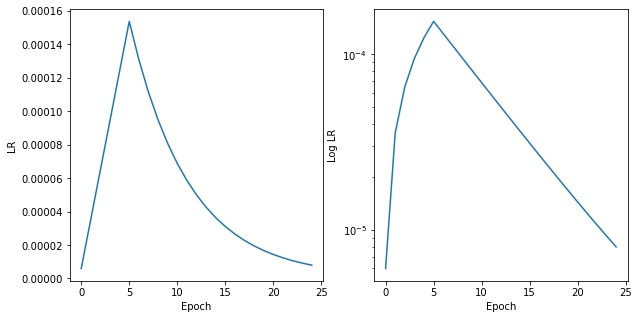

In [15]:
mult       = 1
lr_start   = 6e-6
lr_max     = 1.2e-6 * GLOBAL_BATCH_SIZE
lr_min     = 1e-6
lr_ramp_ep = 5
lr_sus_ep  = 0
lr_decay   = 0.85


def lrfn(epoch):
    if epoch < lr_ramp_ep:
        lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
    elif epoch < lr_ramp_ep + lr_sus_ep:
        lr = lr_max
    else:
        lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
    return lr * mult
    

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot([lrfn(e) for e in range(EPOCHS)])
plt.xlabel('Epoch'); plt.ylabel('LR')
plt.subplot(1, 2, 2)
plt.plot([lrfn(e) for e in range(EPOCHS)])
plt.xlabel('Epoch'); plt.ylabel('Log LR')
plt.yscale('log');

# Training

In [16]:
# build checkpoint folder
CKPT_FOLDER = "../working/ckpt"
if not os.path.exists(CKPT_FOLDER):
    os.mkdir(CKPT_FOLDER)
# build folds
folds = list(model_selection.KFold(n_splits=FOLDS, shuffle=True, random_state=SEED).split(np.arange(15)))
testiness = pd.read_csv("../input/testiness/testiness.csv")
#
TOTAL_POS = 581 + 2858 * INCLUDE_2019 + 1651 * INCLUDE_2018 + 580 * INCLUDE_MALIGNANT

####################################################################
####################		Fold 0		####################
####################################################################
Train files: 27		 Valid files: 3
165527552/165527152 [==============================] - 2s 0us/step
Using balanced dataset with pos_ratio = 8%
Training...
Epoch 1/25
174/174 [==============================] - 117s 672ms/step - auc: 0.5551 - loss: 0.5674 - val_auc: 0.5877 - val_loss: 0.4670 - lr: 6.0000e-06
Epoch 2/25
174/174 [==============================] - 75s 432ms/step - auc: 0.7289 - loss: 0.3124 - val_auc: 0.7779 - val_loss: 0.2528 - lr: 3.5520e-05
Epoch 3/25
174/174 [==============================] - 75s 431ms/step - auc: 0.7817 - loss: 0.3387 - val_auc: 0.8134 - val_loss: 0.2346 - lr: 6.5040e-05
Epoch 4/25
174/174 [==============================] - 75s 434ms/step - auc: 0.8037 - loss: 0.2746 - val_auc: 0.8375 - val_loss: 0.2307 - lr: 9.4560e-05
Epoch 5/25
174/174 [===========================

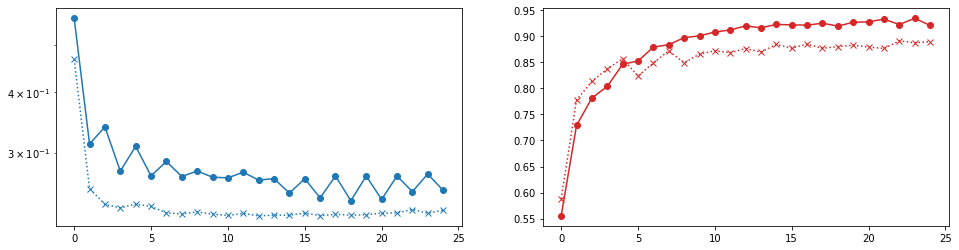




####################################################################
####################		Fold 1		####################
####################################################################
Train files: 27		 Valid files: 3
Using balanced dataset with pos_ratio = 8%
Training...
Epoch 1/25
174/174 [==============================] - 112s 645ms/step - auc: 0.5364 - loss: 0.5879 - val_auc: 0.5964 - val_loss: 0.5810 - lr: 6.0000e-06
Epoch 2/25
174/174 [==============================] - 76s 435ms/step - auc: 0.7293 - loss: 0.3099 - val_auc: 0.7616 - val_loss: 0.2584 - lr: 3.5520e-05
Epoch 3/25
174/174 [==============================] - 76s 434ms/step - auc: 0.7837 - loss: 0.3407 - val_auc: 0.8013 - val_loss: 0.2345 - lr: 6.5040e-05
Epoch 4/25
174/174 [==============================] - 76s 436ms/step - auc: 0.8187 - loss: 0.2748 - val_auc: 0.8012 - val_loss: 0.2886 - lr: 9.4560e-05
Epoch 5/25
174/174 [==============================] - 75s 433ms/step - auc: 0.8457 - loss: 0.3053 - val_auc: 0.

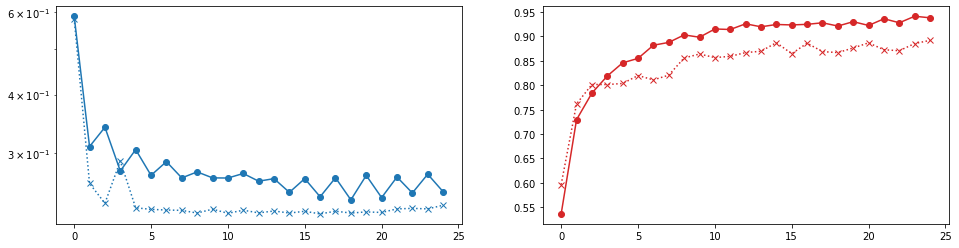




####################################################################
####################		Fold 2		####################
####################################################################
Train files: 27		 Valid files: 3
Using balanced dataset with pos_ratio = 8%
Training...
Epoch 1/25
174/174 [==============================] - 113s 651ms/step - auc: 0.5457 - loss: 0.5895 - val_auc: 0.6002 - val_loss: 0.5132 - lr: 6.0000e-06
Epoch 2/25
174/174 [==============================] - 76s 438ms/step - auc: 0.7128 - loss: 0.3144 - val_auc: 0.7773 - val_loss: 0.2471 - lr: 3.5520e-05
Epoch 3/25
174/174 [==============================] - 77s 442ms/step - auc: 0.7695 - loss: 0.3437 - val_auc: 0.8034 - val_loss: 0.2347 - lr: 6.5040e-05
Epoch 4/25
174/174 [==============================] - 77s 440ms/step - auc: 0.8272 - loss: 0.2738 - val_auc: 0.8470 - val_loss: 0.2558 - lr: 9.4560e-05
Epoch 5/25
174/174 [==============================] - 76s 437ms/step - auc: 0.8418 - loss: 0.3072 - val_auc: 0.

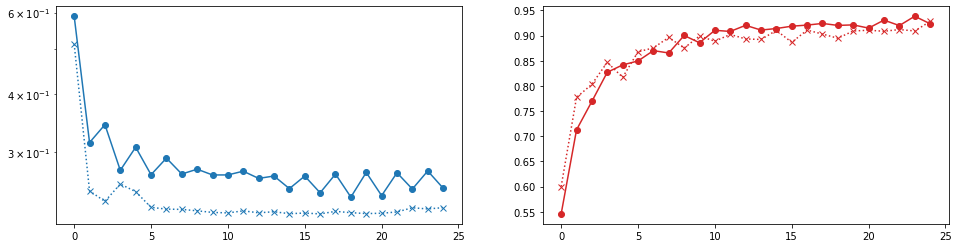




Forecasted total time till next fold completion = 11669 (budget = 9000)


In [17]:
VERBOSE = 1
PLOT    = 1

histories = []
df_oof = pd.DataFrame(); df_res = pd.DataFrame()
t_start = time.time()
for fold, (idTrain, idValid) in enumerate(folds):
    print("#" * 68)
    print(("#" * 20 + "\t\tFold %d\t\t" + "#" * 20) % fold)
    print("#" * 68)
    # prepare TPU
    if DEVICE == 'TPU':
        if tpu: 
            tf.tpu.experimental.initialize_tpu_system(tpu)
    # build fold train-valid split   
    fold_valid_files = [f for f in train_files if any([int(re.match("^train([0-9]+)", f.split("/")[-1]).group(1)) % 15 == i for i in idValid])]
    fold_valid_files = [f for f in fold_valid_files if GCS_PATH1 in f] # only data from the original dataset
    # fold_train_files = [f for f in train_files if any([int(re.match("^train([0-9]+)", f.split("/")[-1]).group(1)) % 15 == i for i in idTrain])]
    fold_train_files = [f for f in train_files if f not in fold_valid_files]
    np.random.shuffle(fold_train_files)
    print("Train files: %d\t\t Valid files: %d" % (len(fold_train_files), len(fold_valid_files)))
    # build model and set precision policy
    K.clear_session()   
    if DEVICE == 'TPU':
        keras.mixed_precision.experimental.set_policy('mixed_bfloat16')
    with strategy.scope():
        model = build_model(dim=IMG_SIZE, ef=EFF_NET)
#        model.load_weights('')
    # callbacks
    FOLD_CKPT_FOLDER = os.path.join(CKPT_FOLDER, "fold%d" % fold)
    if not os.path.exists(FOLD_CKPT_FOLDER):
        os.mkdir(FOLD_CKPT_FOLDER)
    callbacks =[
        keras.callbacks.ModelCheckpoint(os.path.join(FOLD_CKPT_FOLDER, "model_fold%d_e{epoch:02d}.h5" % fold), save_weights_only=True),
        keras.callbacks.LearningRateScheduler(lrfn)
    ]    
    # build ds
    if BALANCE_POS_RATIO:
        print("Using balanced dataset with pos_ratio = %d%%" % int(100 * BALANCE_POS_RATIO))
        ds_train = get_balanced_dataset(fold_train_files, repeat=True,  augment=True,  drop_remainder=True,  shuffle=True,  
                                        pos_ratio=BALANCE_POS_RATIO,
                                        dim=IMG_SIZE, read_dim=IMG_READ_SIZE, batch_size=GLOBAL_BATCH_SIZE)
        FOLD_POS = TOTAL_POS * (FOLDS - 1) / FOLDS
        STEPS = int(FOLD_POS / BALANCE_POS_RATIO / GLOBAL_BATCH_SIZE)
    else:
        print("Using unbalanced dataset")
        ds_train = get_dataset(fold_train_files, repeat=True,  augment=[dropout_aug],  drop_remainder=True,  shuffle=True,  
                               dim=IMG_SIZE, read_dim=IMG_READ_SIZE, batch_size=GLOBAL_BATCH_SIZE)
        STEPS = int(count_data_items(fold_train_files) / GLOBAL_BATCH_SIZE)
    ds_valid = get_dataset(fold_valid_files, repeat=False, augment=TTA, drop_remainder=False, shuffle=False, 
                           dim=IMG_SIZE, read_dim=IMG_READ_SIZE, batch_size=GLOBAL_BATCH_SIZE * TBM)
    # train
  
    print("Training...")
    history = model.fit(
                            ds_train,
        validation_data   = ds_valid,
        epochs            = EPOCHS,
        steps_per_epoch   = STEPS,
        verbose           = VERBOSE,
        callbacks         = callbacks,
        validation_freq   = VALID_FREQ
    )
    histories.append(history)    
  
    # SWA
    ckpt_files = np.sort(tf.io.gfile.glob(os.path.join(FOLD_CKPT_FOLDER, "*.h5")))
    ckpt_files_fow_swa = ckpt_files[-N_SWA:]
    if len(ckpt_files_fow_swa) > 1:
        with strategy.scope():
            model = average.average_weights(ckpt_files_fow_swa, decay=SWA_DECAY, model=model)
    for f in ckpt_files:
        os.remove(f)
    model.save(os.path.join(CKPT_FOLDER, "model_fold%d.h5" % fold))
    # VALID
    ds_valid = get_dataset(fold_valid_files, augment=TTA >= 1, repeat=True, dim=IMG_SIZE, read_dim=IMG_READ_SIZE, batch_size=GLOBAL_BATCH_SIZE * TBM, drop_remainder=True)
    ct_valid = count_data_items(fold_valid_files); STEPS = int(np.ceil(TTA * ct_valid / GLOBAL_BATCH_SIZE / TBM))
    fold_valid_pred = model.predict(ds_valid, steps=STEPS, verbose=1)
    fold_valid_pred = fold_valid_pred[:ct_valid * TTA,]
    ds_valid = get_dataset(fold_valid_files, augment=False, repeat=False, dim=IMG_SIZE, batch_size=GLOBAL_BATCH_SIZE * TBM, drop_remainder=False, labeled=False)
    fold_valid_names = np.concatenate([np.array([ni.decode("utf-8") for ni in n.numpy()]) for n in ds_valid.map(lambda i, n: n)], 0)
   
    fold_df = pd.DataFrame({'image_name': np.tile(fold_valid_names, [TTA]), 'pred': fold_valid_pred.squeeze(), 'fold': fold})
    df_oof = pd.concat([df_oof, fold_df])
    fold_df['image_name'] = fold_df['image_name'].str.replace('_downsampled', '')
    fold_df = fold_df.groupby('image_name').mean().reset_index()
    fold_df = fold_df.merge(df_base_train[['image_name', 'patient_id', 'target']], on='image_name').merge(testiness, on='image_name')
    fold_df['fold'] = fold
    auc  = metrics.roc_auc_score(fold_df.target, fold_df.pred)
  
    # TEST
    ds_test = get_dataset(test_files, augment=TTA >= 1, repeat=True, dim=IMG_SIZE, read_dim=IMG_READ_SIZE, batch_size=GLOBAL_BATCH_SIZE * TBM, drop_remainder=True, labeled=False)
    ct_test = count_data_items(test_files); STEPS = int(np.ceil(TTA * ct_test / GLOBAL_BATCH_SIZE / TBM))
    fold_test_pred = model.predict(ds_test.map(lambda i, l: i), steps=STEPS, verbose=1)
    fold_test_pred = fold_test_pred[:ct_test * TTA,]
    ds_test = get_dataset(test_files, augment=False, repeat=False, dim=IMG_SIZE, batch_size=GLOBAL_BATCH_SIZE * TBM, drop_remainder=False, labeled=False)
    fold_test_names = np.concatenate([np.array([ni.decode("utf-8") for ni in n.numpy()]) for n in ds_test.map(lambda i, n: n)], 0)
  
    fold_res = pd.DataFrame({'image_name': np.tile(fold_test_names, [TTA]), 'pred': fold_test_pred.squeeze(), 'fold': fold})
    df_res = pd.concat([df_res, fold_res])
  
    # time
    used_time_till_now = time.time() - t_start
    time_per_fold = used_time_till_now / (fold + 1)
    print("Validation AUC last epoch = %.4f" % history.history['val_auc'][-1])
    print("Validation AUC  (TTA %2d) = %.4f" % (TTA, auc))
    print("Total time = %ds\t\tTime per fold = %ds" % (int(used_time_till_now), int(time_per_fold)))
  
    # plot
    if PLOT:
        plt.figure(figsize=(16, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'], color='tab:blue', marker='o')
        plt.plot(range(VALID_FREQ - 1, EPOCHS, VALID_FREQ), history.history['val_loss'], color='tab:blue', marker='x', linestyle=':')
        plt.yscale('log')
        plt.subplot(1, 2, 2)
        plt.plot(history.history['auc'], color='tab:red', marker='o')
        plt.plot(range(VALID_FREQ - 1, EPOCHS, VALID_FREQ), history.history['val_auc'], color='tab:red', marker='x', linestyle=':')
        plt.show()
  
    del model, ds_train, ds_valid, ds_test
    print("\n\n")
  
    if (fold + 1) < FOLDS:
        # time: if next iteration will exceed the time budget, abort
        time_till_next_fold = used_time_till_now + time_per_fold
        if time_till_next_fold > TIME_BUDGET:
            print("Forecasted total time till next fold completion = %d (budget = %d)" % (time_till_next_fold, TIME_BUDGET))
            break
    pass

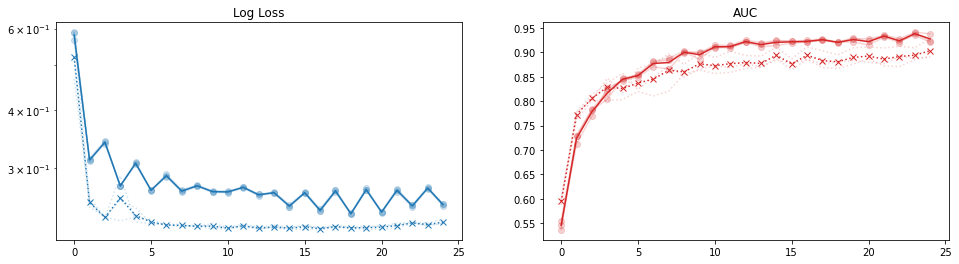

In [18]:
avgh = dict()
for history in histories:
    for k in history.history.keys():
        if k in avgh.keys():
            avgh[k] = np.concatenate([avgh[k], np.array(history.history[k]).reshape(-1, 1)], 1)
        else:
            avgh[k] = np.array(history.history[k]).reshape(-1, 1)
plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.title('Log Loss')
plt.plot(avgh['loss'], marker='o', color='tab:blue', alpha=0.2)
plt.plot(avgh['loss'].mean(1), color='tab:blue')
plt.plot(range(VALID_FREQ - 1, EPOCHS, VALID_FREQ), avgh['val_loss'], color='tab:blue', alpha=0.2, linestyle=":")
plt.plot(range(VALID_FREQ - 1, EPOCHS, VALID_FREQ), avgh['val_loss'].mean(1), marker='x', color='tab:blue', linestyle=":")
plt.yscale('log')
plt.subplot(1, 2, 2)
plt.title('AUC')
plt.plot(avgh['auc'], marker='o', color='tab:red', alpha=0.2)
plt.plot(avgh['auc'].mean(1), color='tab:red')
plt.plot(range(VALID_FREQ - 1, EPOCHS, VALID_FREQ), avgh['val_auc'], color='tab:red', alpha=0.2, linestyle=":")
plt.plot(range(VALID_FREQ - 1, EPOCHS, VALID_FREQ), avgh['val_auc'].mean(1), marker='x', color='tab:red', linestyle=":");

## TTA Analysis

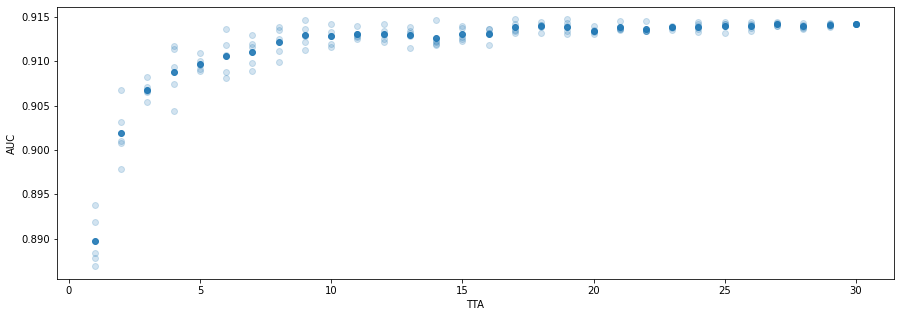

In [19]:
R = 5
df = df_oof.merge(df_base_train[['image_name', 'patient_id', 'target']], on='image_name').merge(testiness, on='image_name')
plt.figure(figsize=(15, 5))
for N in range(1, TTA + 1):
    aucs = []; caucs = []
    for r in range(R):
        df_i = df.sample(frac=1.0).groupby('image_name').tail(N).groupby('image_name').mean().reset_index()
        aucs.append(metrics.roc_auc_score(df_i.target, df_i.pred))
        caucs.append(metrics.roc_auc_score(df_i.target, df_i.pred, sample_weight=df_i.testiness))
    plt.scatter([N] * R, aucs, color='tab:blue', alpha=0.2)
    plt.scatter(N, sum(aucs) / R, color='tab:blue', alpha=0.9)
plt.xlabel("TTA"); plt.ylabel("AUC");

In [20]:
xxx = df_oof.groupby('image_name').mean().reset_index().merge(df_base_train, on='image_name')
print("OOF AUC (TTA %d) = %.4f" % (TTA, metrics.roc_auc_score(xxx.target, xxx.pred)))

OOF AUC (TTA 30) = 0.9142


In [21]:
df_res.to_csv('../working/test_res_all.csv', index=False)
df_oof.to_csv('../working/oof_res_all.csv', index=False)

In [22]:
df_res[['image_name', 'pred']].groupby('image_name').mean().reset_index().rename({'pred': 'target'}, axis=1).to_csv("submission.csv", index=False)